In [159]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from matplotlib.colors import LogNorm
import cv2
import copy
import math

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize=(14, 7)

from matplotlib import rc
rc('figure', **{'dpi': 150})

import torch
import torch.optim as optim
from torch import nn
from torch.nn import init
from torch.nn.modules import loss
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchinfo import summary

# The Transformer architecture

This implementation has been adapted from [OpenNMT](https://aclanthology.org/P17-4012/) and "[The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)".

In [160]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [161]:
class FeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [162]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [163]:
def clone_layer(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [164]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [165]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clone_layer(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [166]:
class AddNorm(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(AddNorm, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [167]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone_layer(AddNorm(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [168]:
class FeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [169]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute Scaled Dot Product Attention"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [170]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        # linears = (W_V, W_K, W_Q, W_O)
        self.linears = clone_layer(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.last_attn = None  # (B, H, Tq, Tk)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
        self.last_attn = self.attn.detach().cpu()

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [171]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [172]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + torch.autograd.Variable(self.pe[:, :x.size(1)],
                                        requires_grad=False)
        return self.dropout(x)

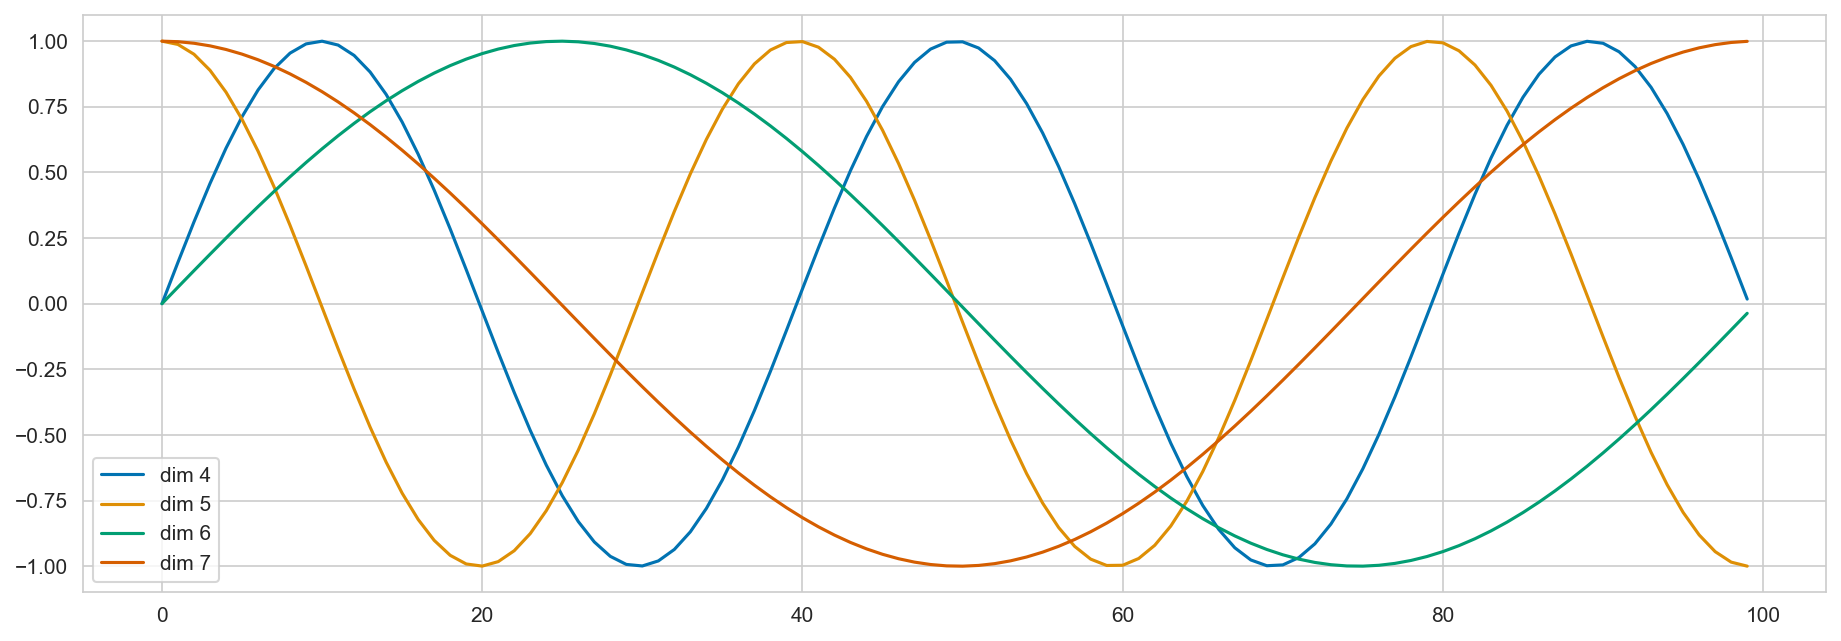

In [173]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.autograd.Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [174]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clone_layer(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [175]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clone_layer(AddNorm(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [176]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.0):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = FeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn),
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))


    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [177]:
small_model=make_model(10, 10, 2)

In [178]:
summary(small_model)

Layer (type:depth-idx)                             Param #
EncoderDecoder                                     --
├─Encoder: 1-1                                     --
│    └─ModuleList: 2-1                             --
│    │    └─EncoderLayer: 3-1                      3,152,384
│    │    └─EncoderLayer: 3-2                      3,152,384
│    └─LayerNorm: 2-2                              1,024
├─Decoder: 1-2                                     --
│    └─ModuleList: 2-3                             --
│    │    └─DecoderLayer: 3-3                      4,204,032
│    │    └─DecoderLayer: 3-4                      4,204,032
│    └─LayerNorm: 2-4                              1,024
├─Sequential: 1-3                                  --
│    └─Embeddings: 2-5                             --
│    │    └─Embedding: 3-5                         5,120
│    └─PositionalEncoding: 2-6                     --
│    │    └─Dropout: 3-6                           --
├─Sequential: 1-4                       

In [179]:
small_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x AddNorm(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True

In [180]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [181]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & torch.autograd.Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [182]:
import time

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [183]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [184]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

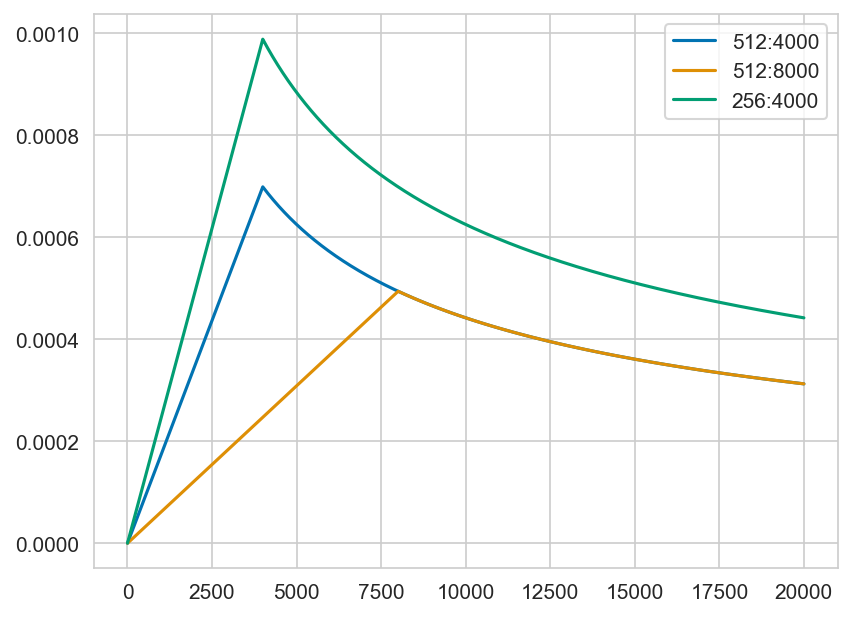

In [185]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [186]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, torch.autograd.Variable(true_dist, requires_grad=False))

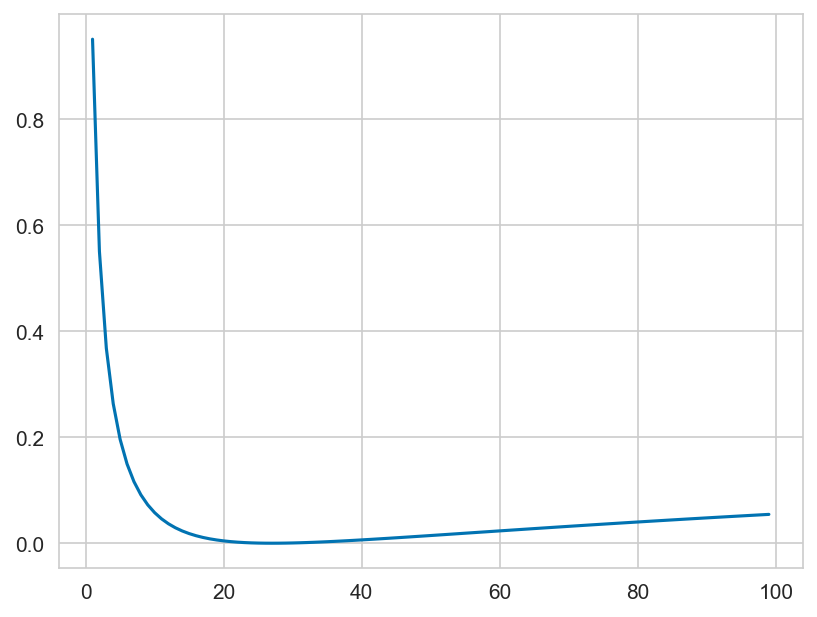

In [187]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0.1, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    return crit(torch.autograd.Variable(predict.log()),
                torch.autograd.Variable(torch.LongTensor([1]))).data
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# Digit inverter

In [188]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt convert task."
    for i in range(nbatches):
        data_src = np.random.randint(1, V, size=(batch, 10))
        data_tgt = V - data_src
        data_src[:, 0] = 0
        data_tgt[:, 0] = 0
        src = torch.autograd.Variable(torch.tensor(data_src), requires_grad=False)
        tgt = torch.autograd.Variable(torch.tensor(data_tgt), requires_grad=False)
        yield Batch(src, tgt, 0)

In [189]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm

In [190]:
# Train the digit inverter task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 4000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(50):
    print(f"Epoch:{epoch}")
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    run_epoch(data_gen(V, 30, 5), model,
              SimpleLossCompute(model.generator, criterion, None))

Epoch:0
Epoch Step: 1 Loss: 3.073527 Tokens per Sec: 2224.299561
Epoch Step: 1 Loss: 2.780697 Tokens per Sec: 2417.350098
Epoch:1
Epoch Step: 1 Loss: 2.920871 Tokens per Sec: 2582.125244
Epoch Step: 1 Loss: 2.422349 Tokens per Sec: 3484.005615
Epoch:2
Epoch Step: 1 Loss: 2.434746 Tokens per Sec: 2692.812012
Epoch Step: 1 Loss: 2.054750 Tokens per Sec: 2461.248047
Epoch:3
Epoch Step: 1 Loss: 2.103213 Tokens per Sec: 1971.479370
Epoch Step: 1 Loss: 1.898456 Tokens per Sec: 3207.167480
Epoch:4
Epoch Step: 1 Loss: 1.899464 Tokens per Sec: 2028.427734
Epoch Step: 1 Loss: 1.739780 Tokens per Sec: 3482.382568
Epoch:5
Epoch Step: 1 Loss: 1.691550 Tokens per Sec: 2588.635742
Epoch Step: 1 Loss: 1.675901 Tokens per Sec: 3512.103760
Epoch:6
Epoch Step: 1 Loss: 1.691004 Tokens per Sec: 2745.269531
Epoch Step: 1 Loss: 1.602887 Tokens per Sec: 3497.342041
Epoch:7
Epoch Step: 1 Loss: 1.655724 Tokens per Sec: 2720.933594
Epoch Step: 1 Loss: 1.484259 Tokens per Sec: 3438.413330
Epoch:8
Epoch Step: 1 Lo

In [191]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           torch.autograd.Variable(ys),
                           torch.autograd.Variable(subsequent_mask(ys.size(1))
                                                  .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = torch.autograd.Variable(torch.LongTensor([[0,1,5,6,3,6,7,7,9,10]]) )
src_mask = torch.autograd.Variable(torch.tensor([[0] + [1]*9])  )
print(src.numpy())
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=0))
print(V - src)

[[ 0  1  5  6  3  6  7  7  9 10]]
tensor([[ 0, 10,  6,  6,  5,  8,  4,  4,  2,  1]])
tensor([[11, 10,  6,  5,  8,  5,  4,  4,  2,  1]])


Visualize attention weights and self-attention weights after each layer for the model trained in this notebook. Are there any interesting or at least easily interpretable patterns?

In [192]:
def visualize_attention(attention_weights, title, token_labels=None, figsize=(14, 7)):
    """
    Visualize attention weights for all layers and heads.

        Args:
        attention_weights: List of attention weight arrays (one per layer)
        title: Title for the overall figure
        token_labels: Optional list of token labels for axes
    """
    n_layers = len(attention_weights)
    if n_layers == 0:
        print(f"No attention weights to visualize for {title}")
        return

    # get dimensions
    n_heads = attention_weights[0].shape[1]

    fig, axes = plt.subplots(n_layers, n_heads, figsize=figsize)
    if n_layers == 1:
        axes = axes.reshape(1, -1)
    if n_heads == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title, fontsize=16)

    for layer_idx in range(n_layers):
        for head_idx in range(n_heads):
            ax = axes[layer_idx, head_idx]

            # get attention layer
            attn = attention_weights[layer_idx][0, head_idx]

            sns.heatmap(
                attn,
                ax=ax,
                cmap="viridis",
                cbar=False,
                square=True,
                vmin=0,
                vmax=1,
            )

            if token_labels is not None:
                ax.set_xticks(np.arange(len(token_labels)) + 0.5)
                ax.set_yticks(np.arange(len(token_labels)) + 0.5)
                ax.set_xticklabels(token_labels, rotation=45, ha='right')
                ax.set_yticklabels(token_labels, rotation=0)

            ax.set_title(f"L{layer_idx+1} H{head_idx+1}", fontsize=10)

            if head_idx == 0:
                ax.set_ylabel(f"Layer {layer_idx+1}\nQuery", fontsize=9)
            if layer_idx == n_layers - 1:
                ax.set_xlabel("Key", fontsize=9)
    plt.tight_layout()
    return fig

In [193]:
def get_attention_weights(model):
    encoder_attn = []
    decoder_self_attn = []
    decoder_cross_attn = []

    # Encoder self-attention
    for layer in model.encoder.layers:
        encoder_attn.append(layer.self_attn.last_attn)

    # Decoder self-attention + cross-attention
    for layer in model.decoder.layers:
        decoder_self_attn.append(layer.self_attn.last_attn)
        decoder_cross_attn.append(layer.src_attn.last_attn)

    return encoder_attn, decoder_self_attn, decoder_cross_attn

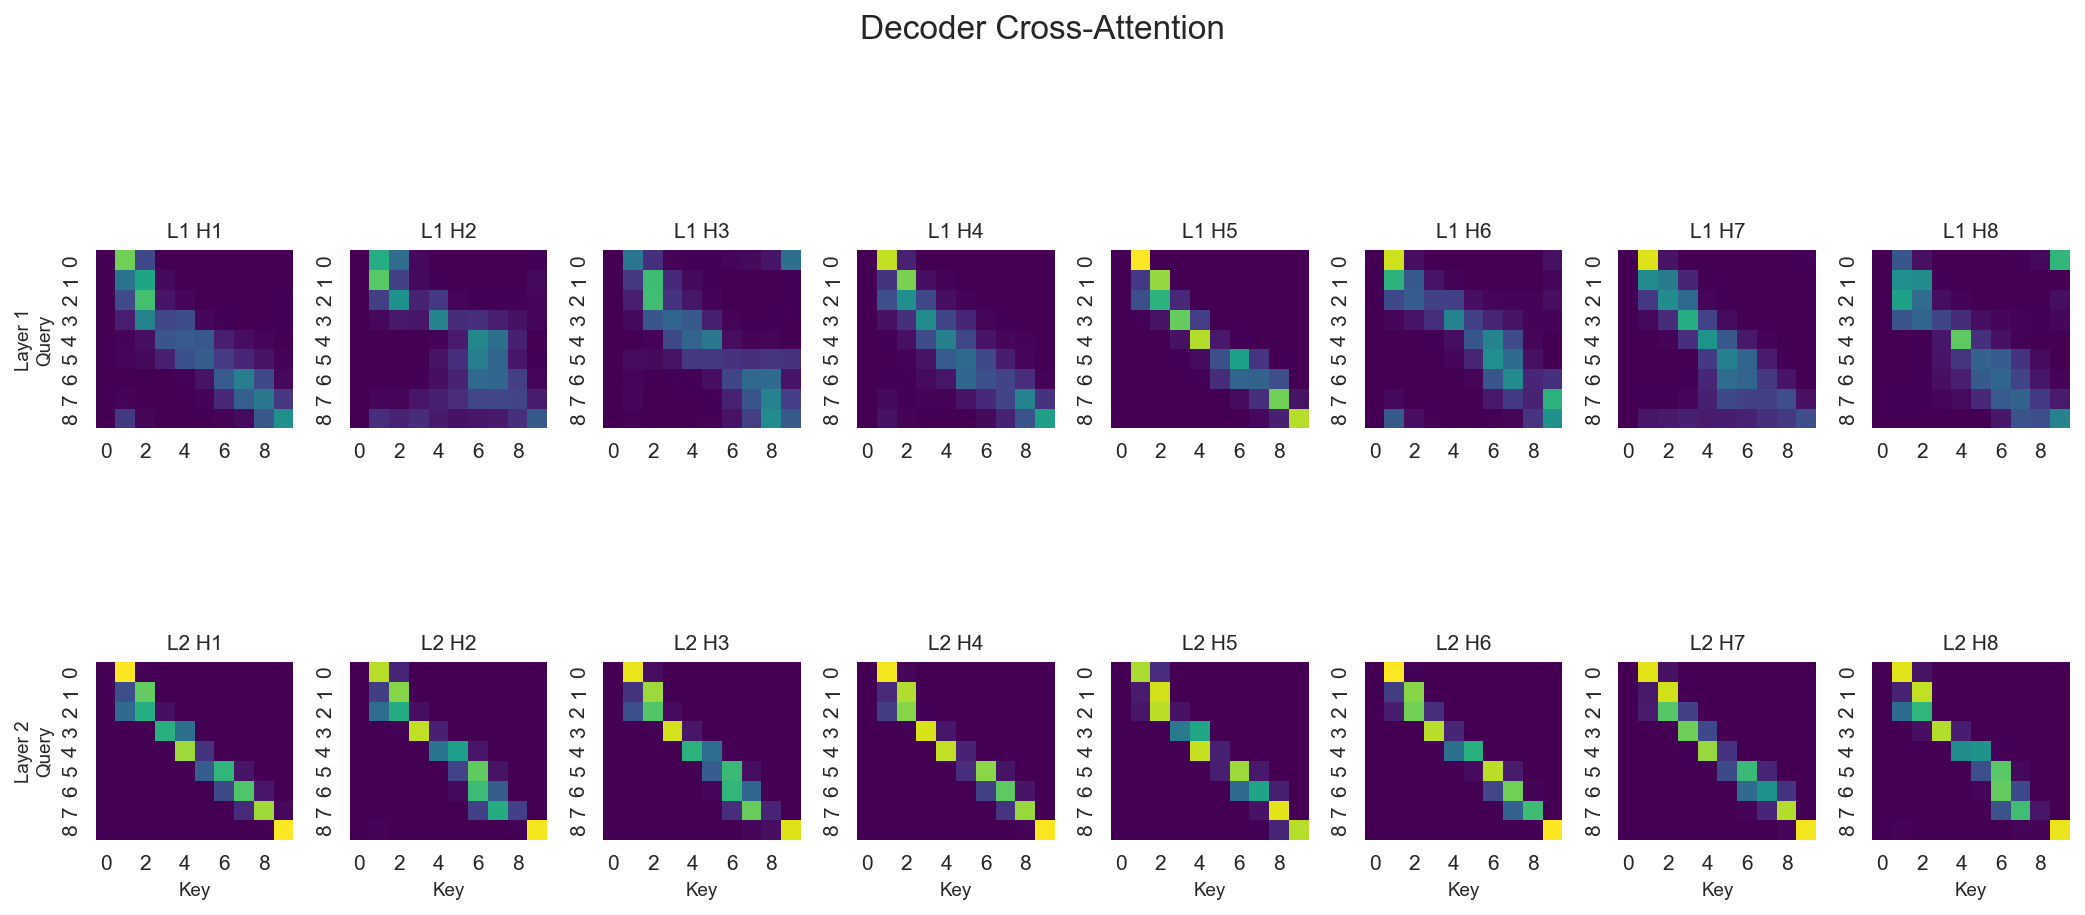

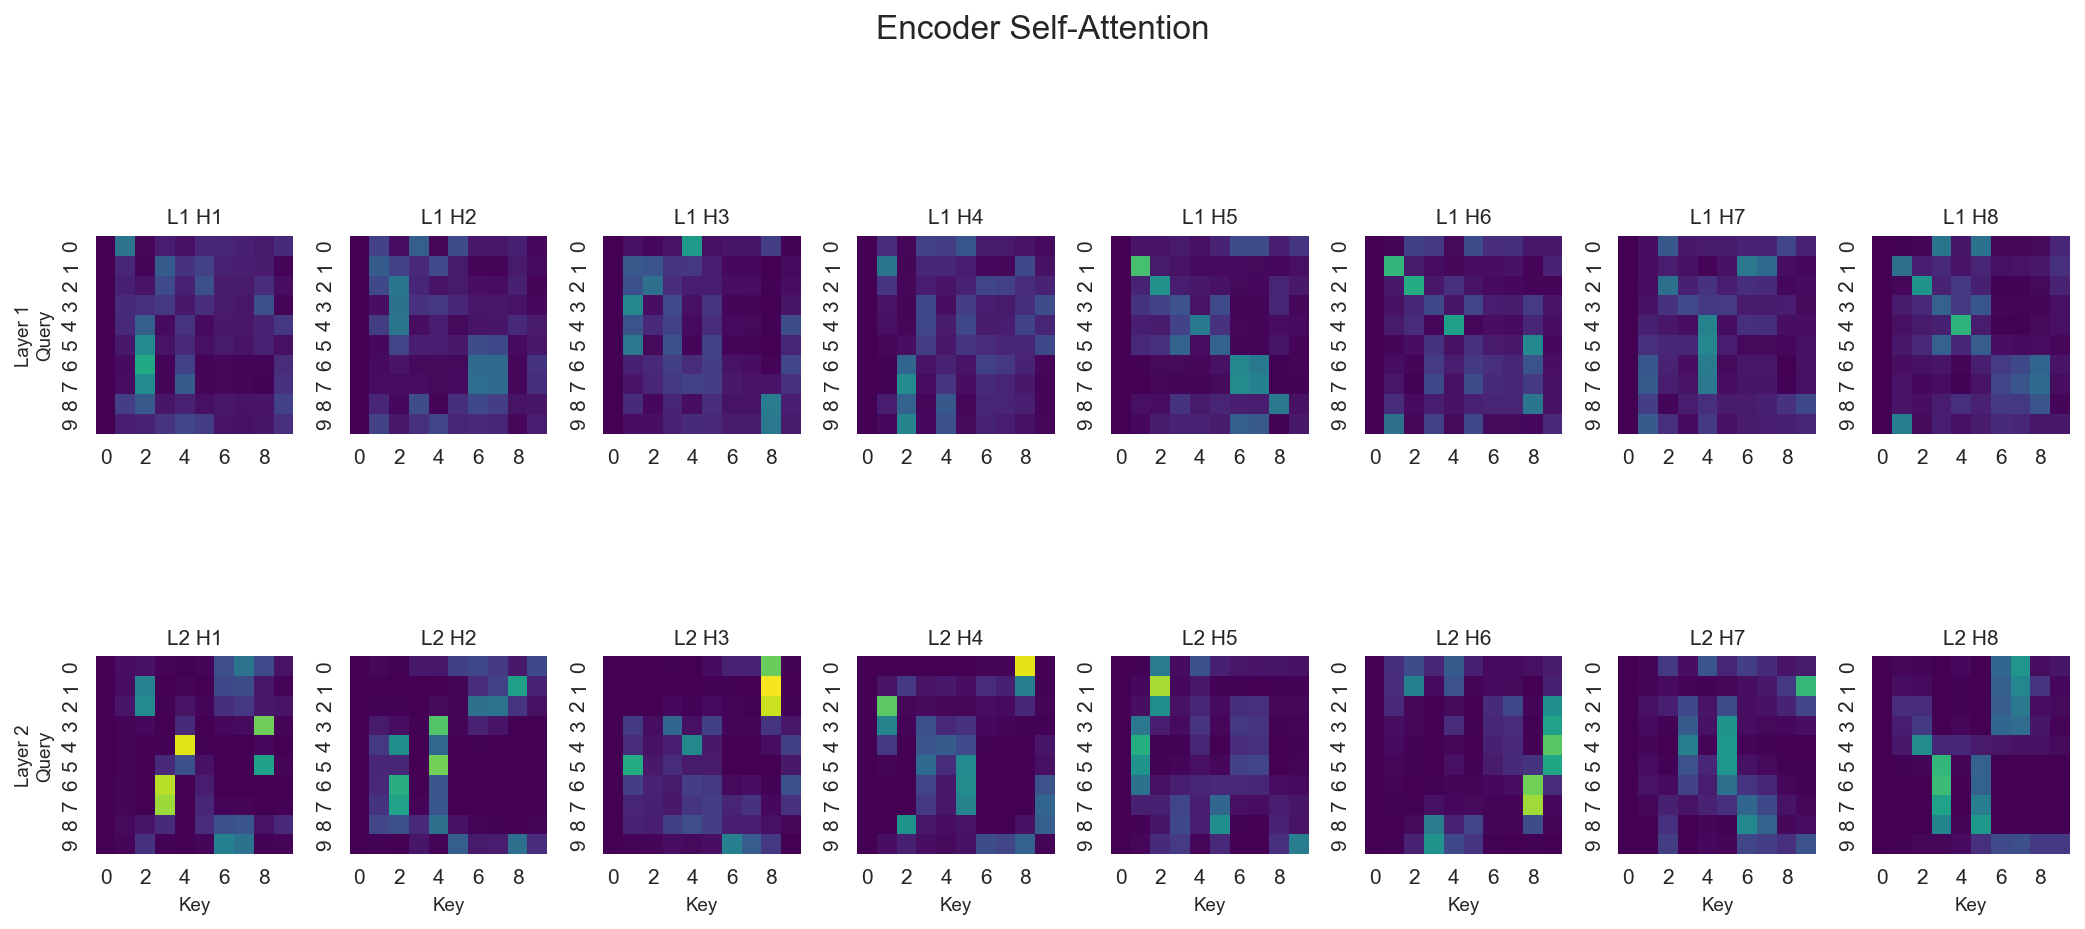

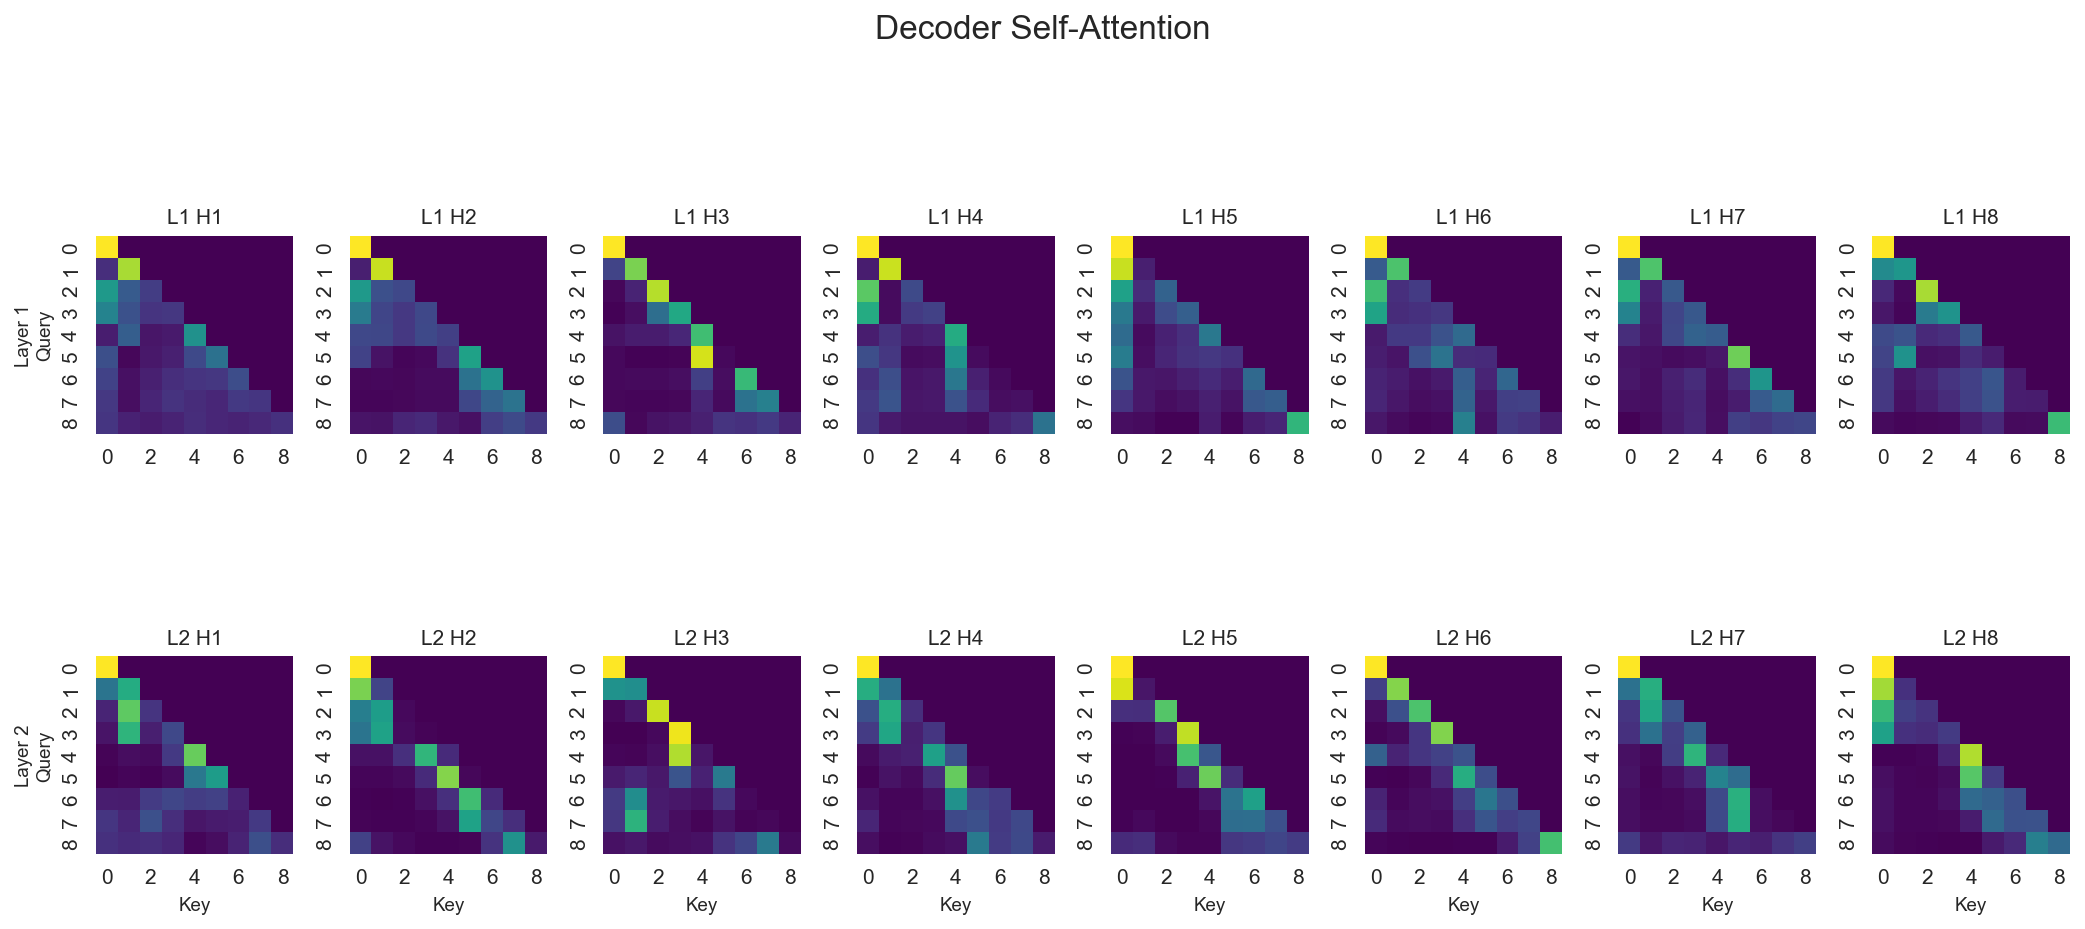

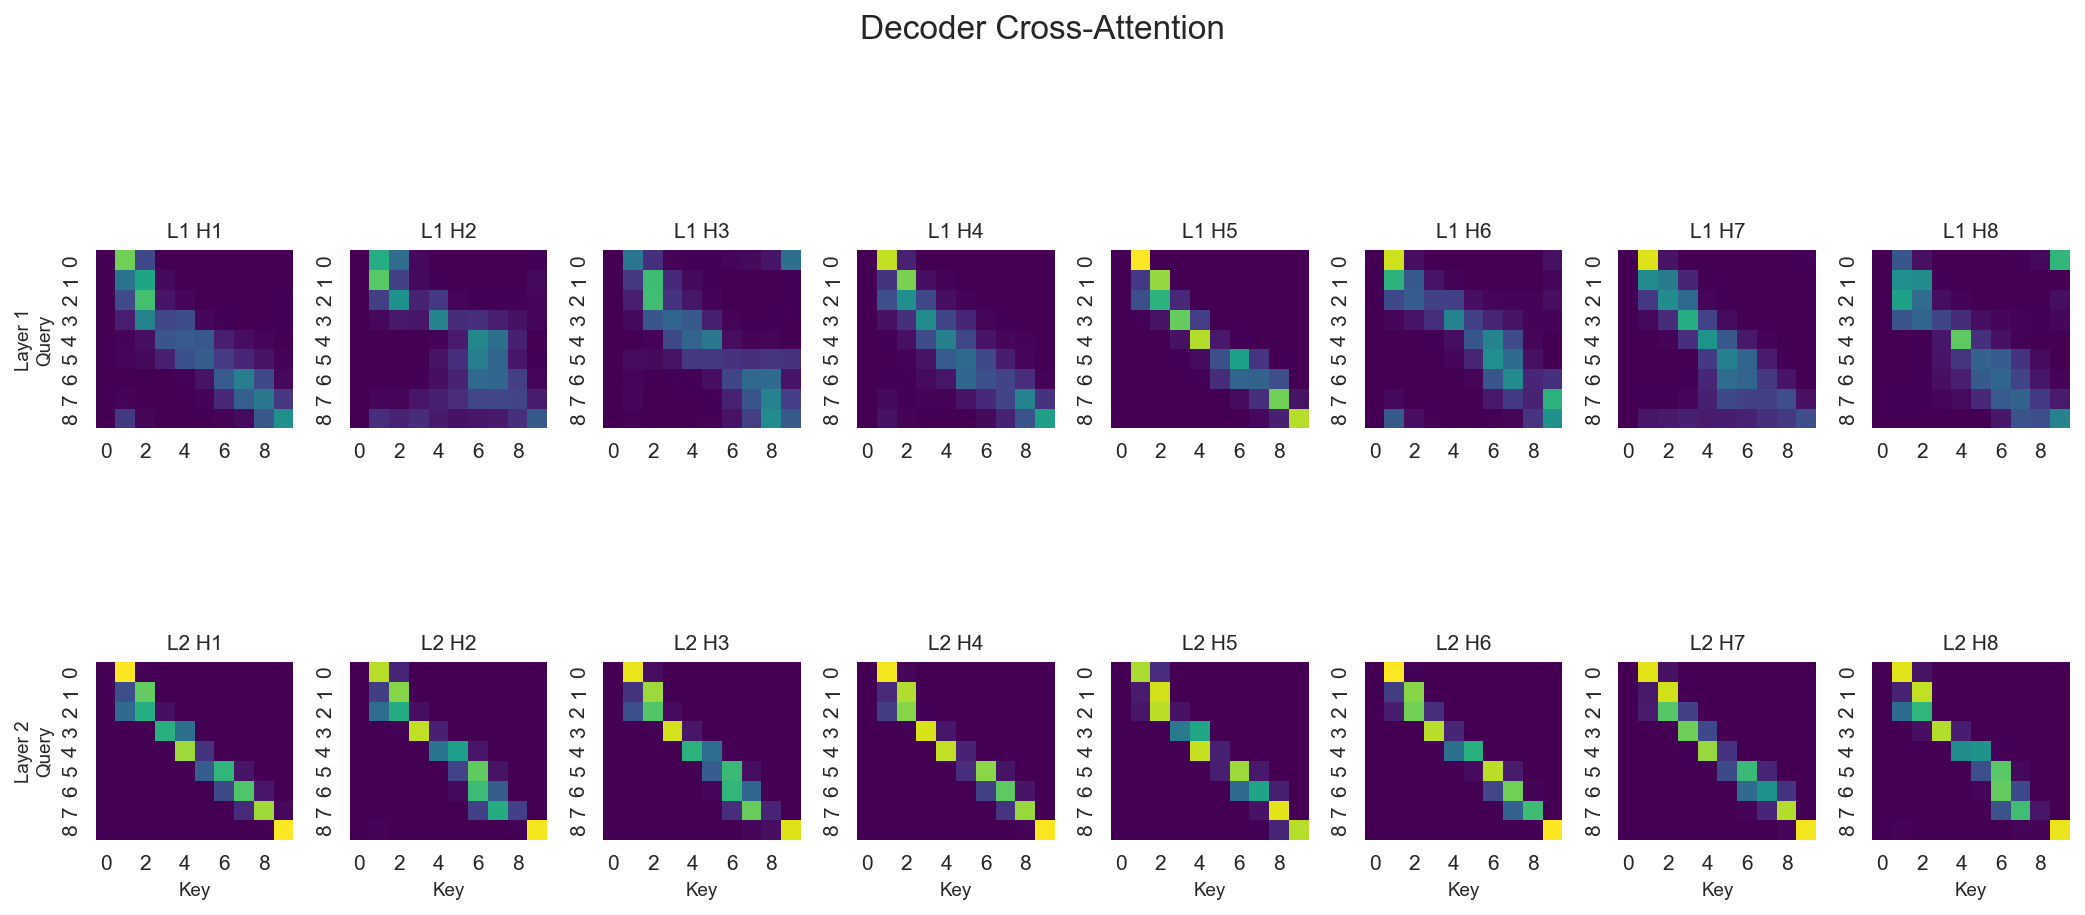

In [194]:
enc_attn, dec_self_attn, dec_cross_attn = get_attention_weights(model)

visualize_attention(enc_attn, "Encoder Self-Attention")
visualize_attention(dec_self_attn, "Decoder Self-Attention")
visualize_attention(dec_cross_attn, "Decoder Cross-Attention")

### Train a new Transformer that takes sequences of digits with length at most 15 and swaps every digit to the next consecutive digit

(let's say wrapping around, so 0 -> 1, 1 -> 2, ..., 9 -> 0).

In [214]:
def data_gen_shift(batch, nbatches, max_len=15):
    PAD = 0

    for _ in range(nbatches):
        lengths = np.random.randint(1, max_len + 1, size=batch)

        src_batch = np.full((batch, max_len), PAD, dtype=np.int64)
        tgt_batch = np.full((batch, max_len + 1), PAD, dtype=np.int64)

        for i, L in enumerate(lengths):
            s = np.random.randint(1, 11, size=L)
            t = (s % 10) + 1 

            src_batch[i, :L] = s

            # start token - NOT use PAD
            tgt_batch[i, 0] = 1
            tgt_batch[i, 1:L+1] = t

        src = torch.tensor(src_batch, dtype=torch.long)
        tgt = torch.tensor(tgt_batch, dtype=torch.long)

        yield Batch(src, tgt, PAD)

In [215]:
V = 11
PAD = 0

criterion = LabelSmoothing(size=V, padding_idx=PAD, smoothing=0.0)
model = make_model(V, V, N=2)

model_opt = NoamOpt(
    model.src_embed[0].d_model,
    factor=1,
    warmup=400,
    optimizer=torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
)

In [216]:
for epoch in range(20):
    print(f"Epoch:{epoch}")
    model.train()
    run_epoch(data_gen_shift(40, 20, max_len=15), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    loss = run_epoch(data_gen_shift(40, 5, max_len=15), model,
                     SimpleLossCompute(model.generator, criterion, None))
    print(f"  Val Loss: {loss:.4f}")

Epoch:0
Epoch Step: 1 Loss: 2.780325 Tokens per Sec: 1539.917236
Epoch Step: 1 Loss: 1.790475 Tokens per Sec: 2022.730835
  Val Loss: 1.7789
Epoch:1
Epoch Step: 1 Loss: 1.831096 Tokens per Sec: 1682.974487
Epoch Step: 1 Loss: 1.494751 Tokens per Sec: 2199.809814
  Val Loss: 1.5768
Epoch:2
Epoch Step: 1 Loss: 1.690800 Tokens per Sec: 1775.237427
Epoch Step: 1 Loss: 1.343537 Tokens per Sec: 2007.806274
  Val Loss: 1.3623
Epoch:3
Epoch Step: 1 Loss: 1.672590 Tokens per Sec: 1806.945923
Epoch Step: 1 Loss: 1.343545 Tokens per Sec: 2484.383057
  Val Loss: 1.3258
Epoch:4
Epoch Step: 1 Loss: 1.333738 Tokens per Sec: 2000.809204
Epoch Step: 1 Loss: 0.992889 Tokens per Sec: 2281.498535
  Val Loss: 0.9463
Epoch:5
Epoch Step: 1 Loss: 1.089400 Tokens per Sec: 1958.401123
Epoch Step: 1 Loss: 0.637214 Tokens per Sec: 2115.527832
  Val Loss: 0.6050
Epoch:6
Epoch Step: 1 Loss: 0.696984 Tokens per Sec: 2081.083740
Epoch Step: 1 Loss: 0.717453 Tokens per Sec: 2277.528564
  Val Loss: 0.6495
Epoch:7
Epoch

In [217]:
model.eval()

src = torch.LongTensor([[1, 5, 6, 3, 6, 7, 7, 9, 10]])
PAD = 0

# build correct target = [START=1] + shifted
shifted = (src % 10) + 1
tgt = torch.cat([torch.ones(1,1).long(), shifted], dim=1)  # [1] + shifted

batch = Batch(src, tgt, PAD)

with torch.no_grad():
    out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
    logp = model.generator(out)
    pred = logp.argmax(dim=-1)


print("Test Results:")
print("Input:    ", src.numpy()[0])
print("Predicted:", pred.numpy()[0])
print("Expected: ", batch.trg_y.numpy()[0])

Test Results:
Input:     [ 1  5  6  3  6  7  7  9 10]
Predicted: [ 2  6  7  4  7  8 10 10  1]
Expected:  [ 2  6  7  4  7  8  8 10  1]


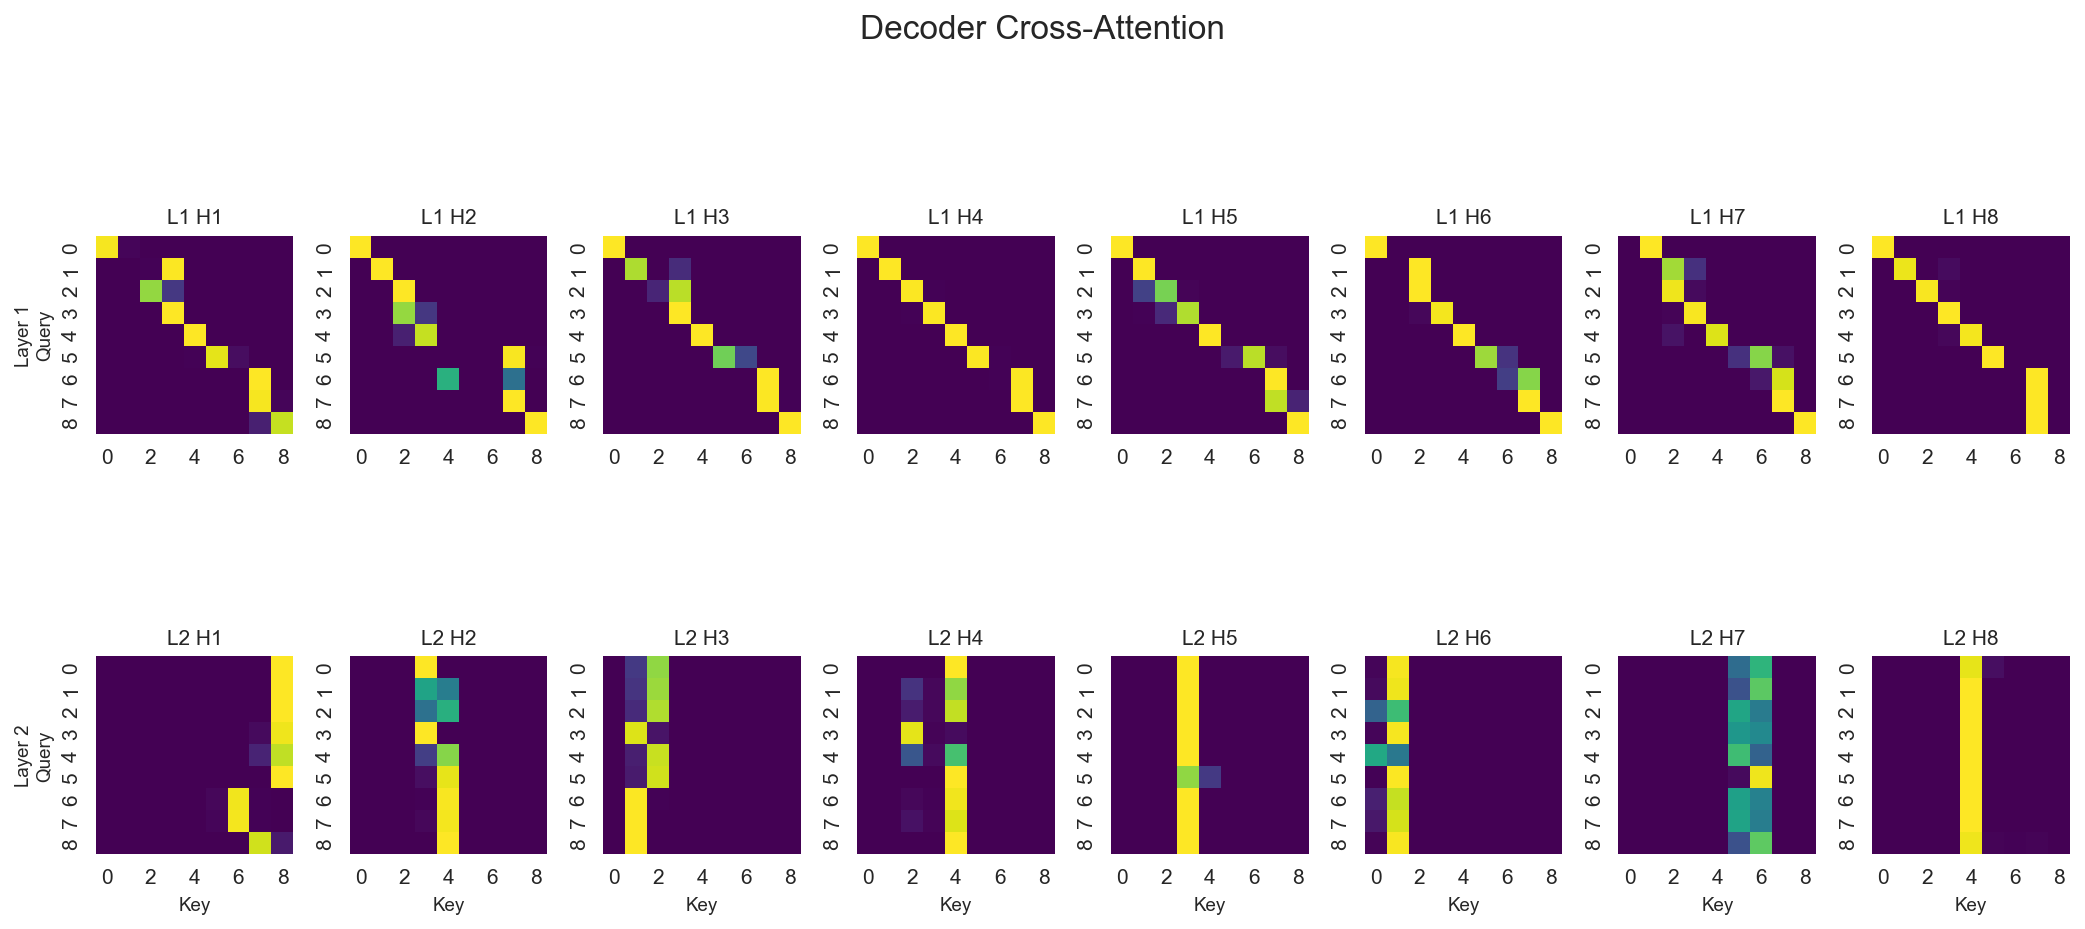

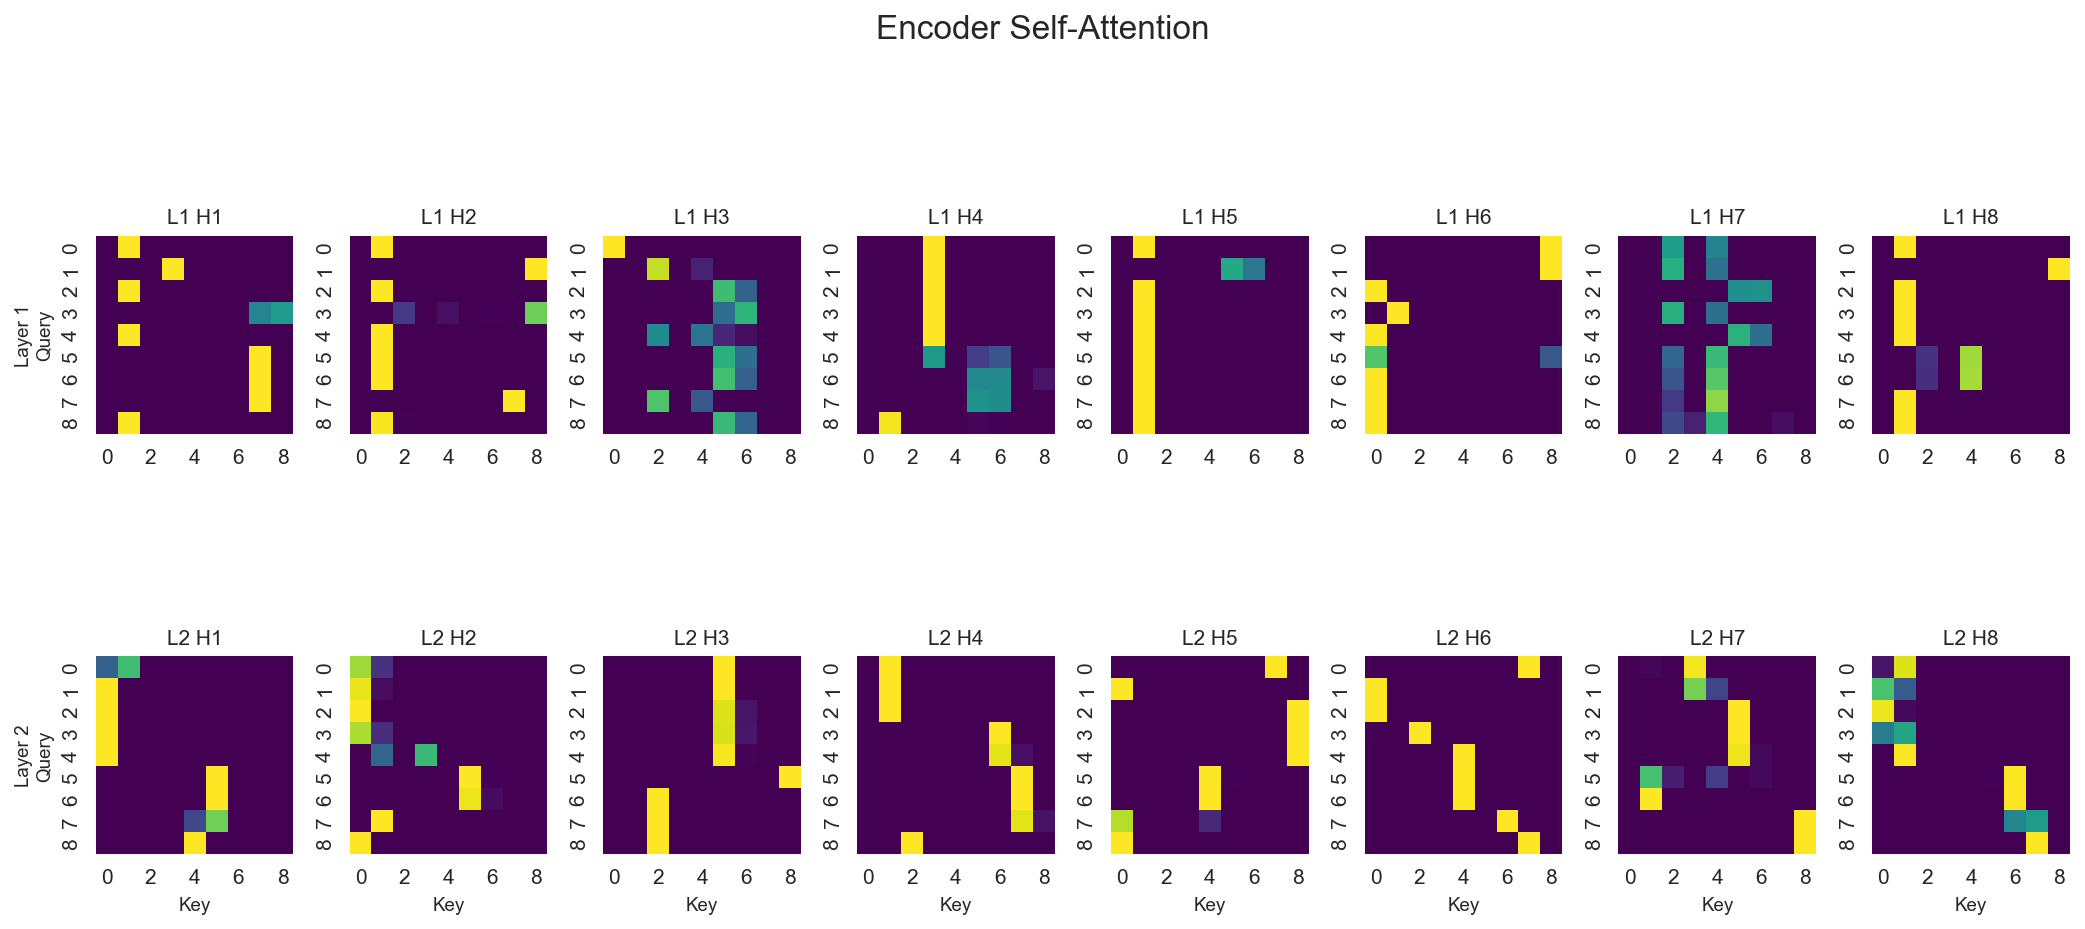

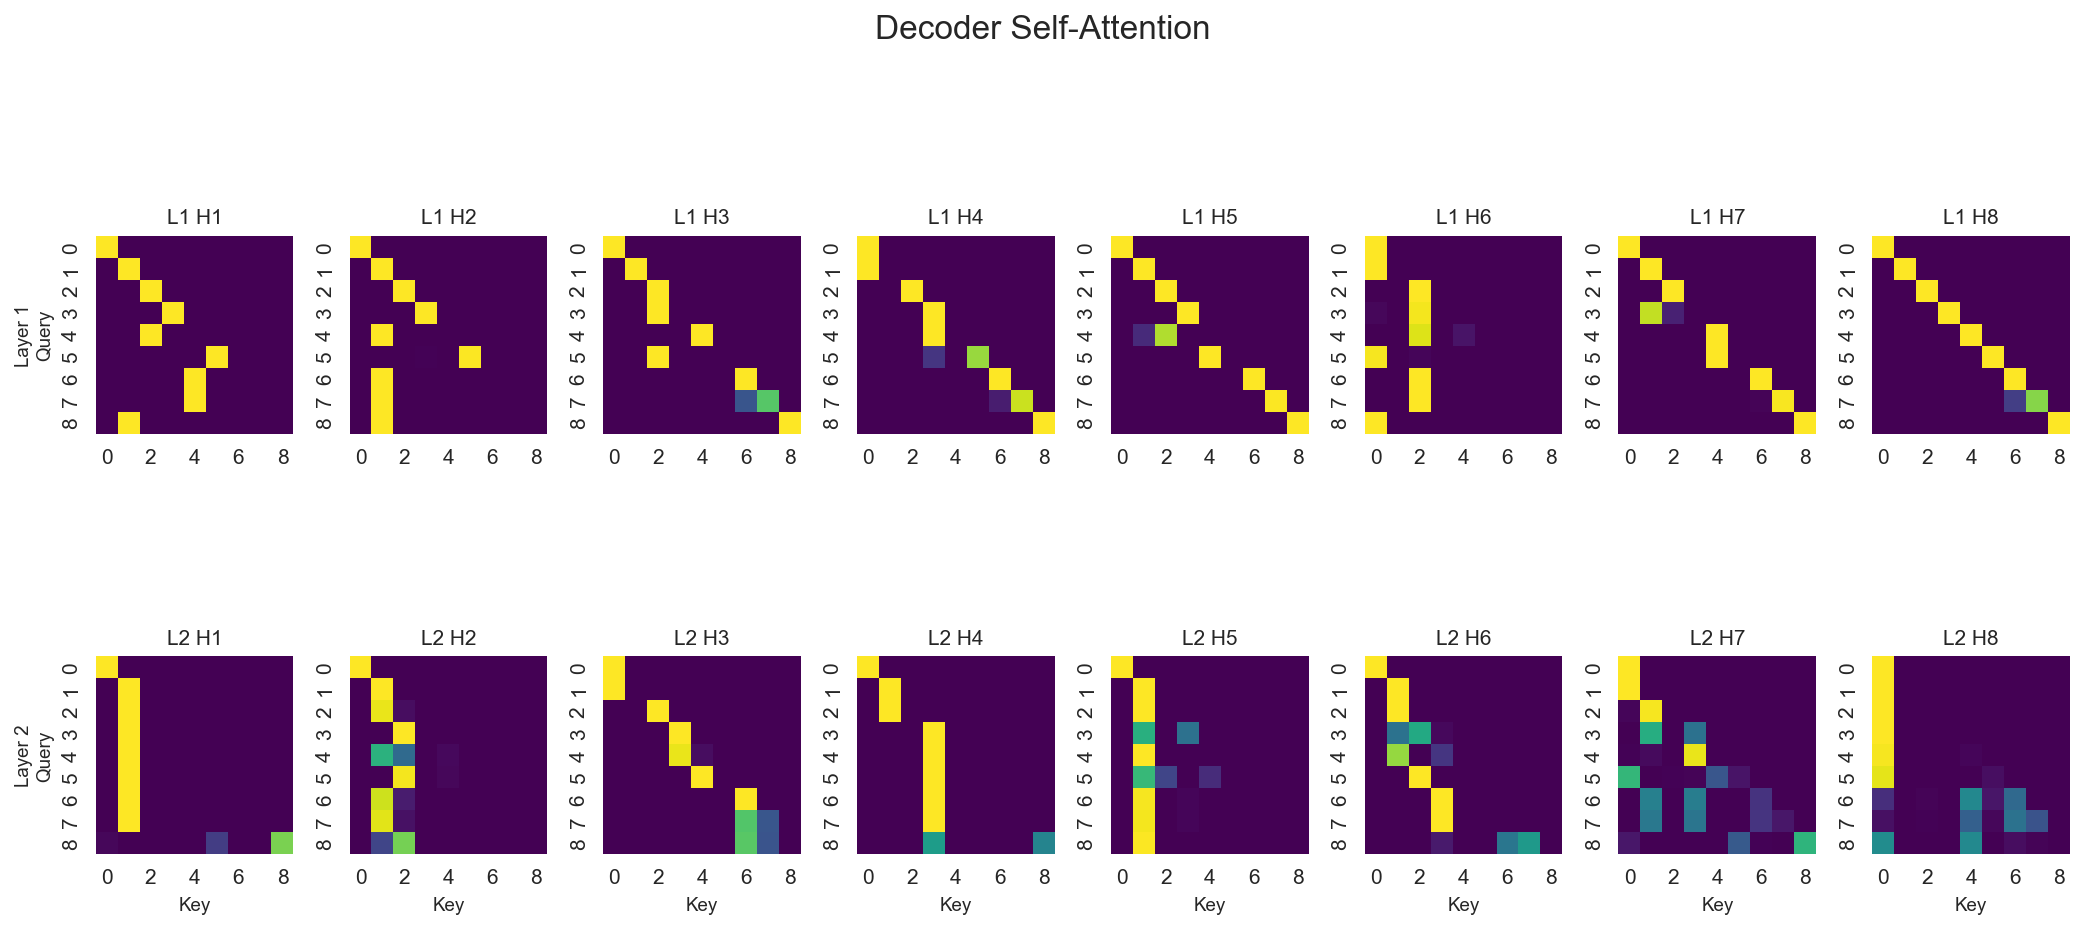

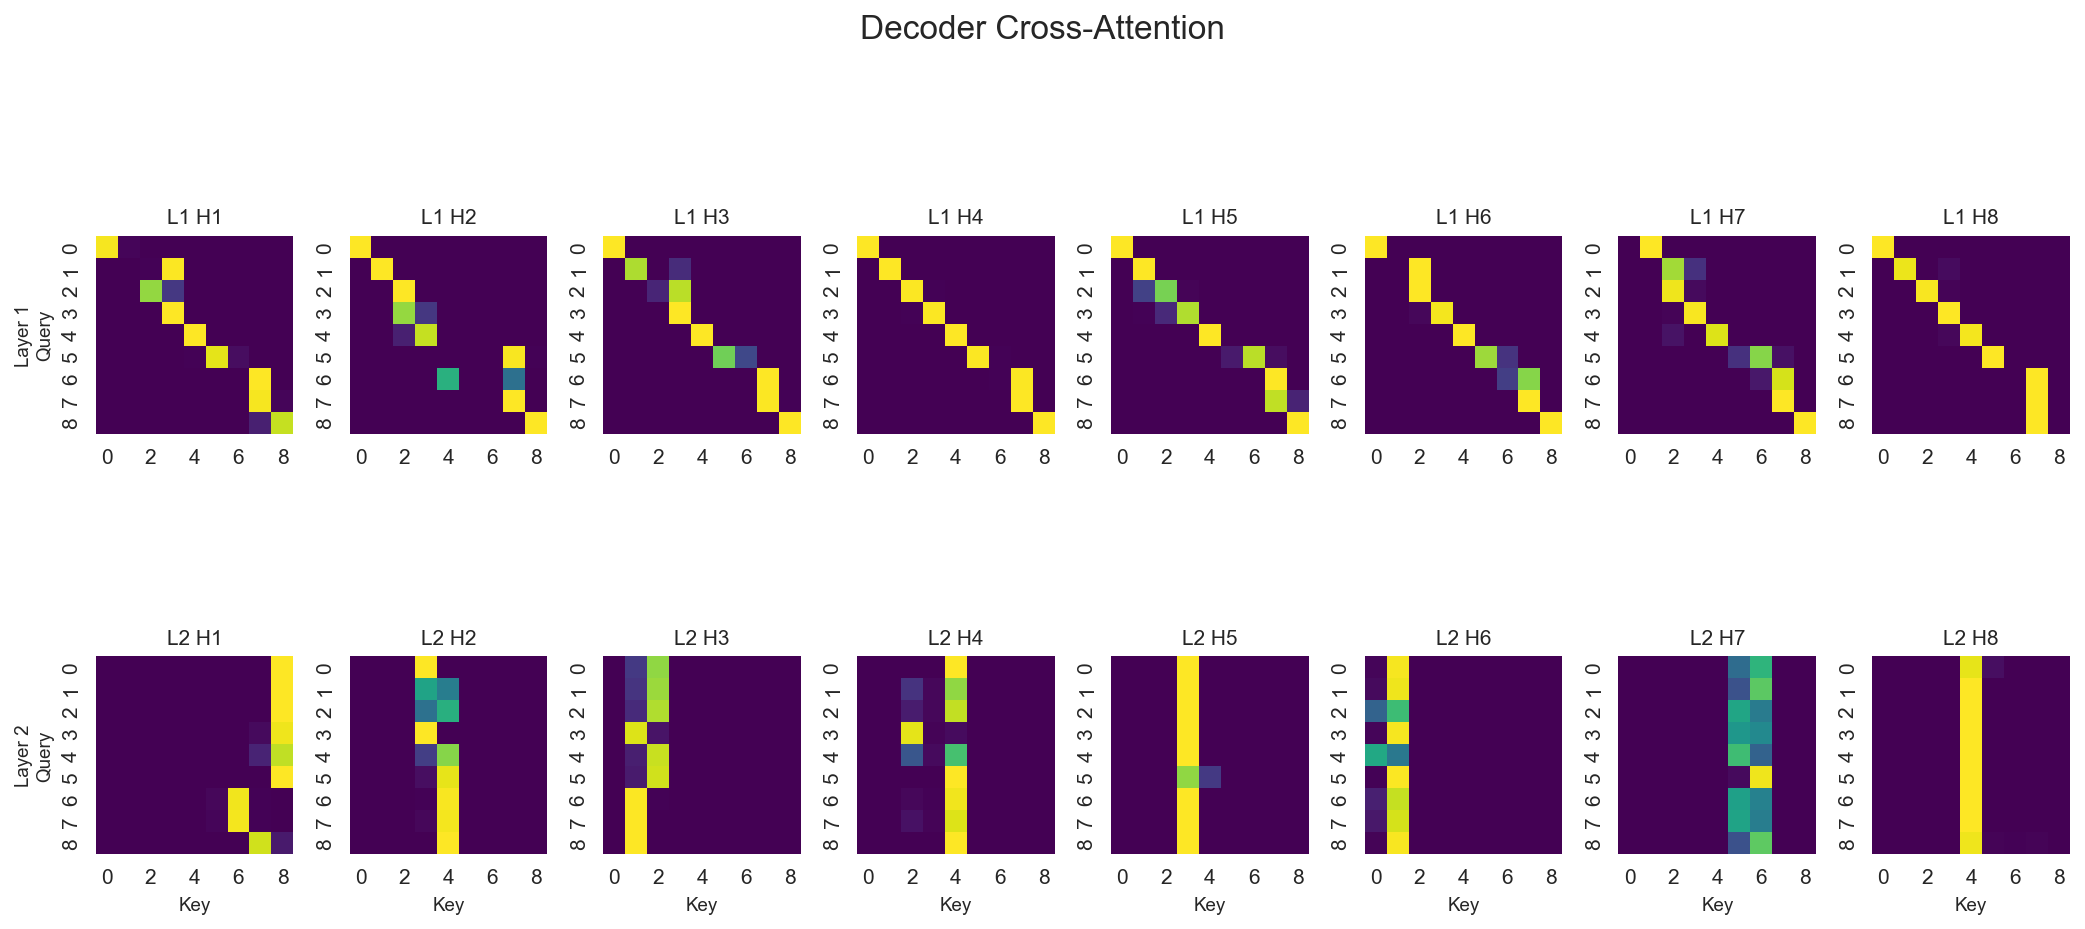

In [218]:
enc_attn, dec_self_attn, dec_cross_attn = get_attention_weights(model)

visualize_attention(enc_attn, "Encoder Self-Attention")
visualize_attention(dec_self_attn, "Decoder Self-Attention")
visualize_attention(dec_cross_attn, "Decoder Cross-Attention")